In [1]:
%matplotlib inline
import pandas as pd
import os, random
import numpy as np
from pathlib import Path
from collections import Counter
from collections import OrderedDict
import pickle
from zipfile import ZipFile
from datetime import datetime
from itertools import cycle

# Import and View Files

In [3]:
filename = '/Users/vickyli/Documents/DS_P449_KiwiBank/filesSSASK.pickle'
with open(filename, 'rb') as handle:
   ssask_files = pickle.load(handle)
# ssask_files

In [4]:
def show_file(file):
   with open(file) as f:
       print(f.read())

In [5]:
# Show a random file from the list of files
random.shuffle(ssask_files)

file = '/Users/vickyli/Documents/DS_P449_KiwiBank/' + ssask_files[0]

show_file(file)


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_05_06\06\19\192747-62E0FB4DB91E0D051BA0EB2AF67B46F6\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_05_06\06\19\192747-62E0FB4DB91E0D051BA0EB2AF67B46F6\kbva.calllog
#=====================================================================
start.time=06/05/2019 19:27:47.642
start.sessionID=62E0FB4DB91E0D051BA0EB2AF67B46F6
start.callData.call.request.anum=
start.callData.call.request.module=ssask
start.callData.call.request.pd=
start.callData.call.request.pt=account
start.callData.call.request.pu=balance
start.callData.call.request.ref=152796.30704
#=====================================================================
prompt[1].text=Would you like to use phone banking to hear your balance?
#=====================================================================
rec[1].startTime=06/05/2019 19:27:47.688
rec[1].state=OfferSelfService
rec[1].reason=OK
rec[1].inputmode=speech
rec[1].utterance[1]=yes please
rec[1].endTime=06/05/2

In [ ]:
# Questions for exploring:
### - assumption for module process (is it based on the number calling from?)
### - assumption for log documentation in general
### - disconnected customers (what type, how long and why?)

In [6]:
# Create a function for flattening the log information

def read_log_file(filename):
    with open(filename) as f:
       line_list = f.readlines()
    
    read_bln = False
    temp_dict = {}
    rec_count = 0
    
    for n in range(len(line_list)):
        
        line = line_list[n]
        
        if line[0] == "#":
            read_bln = True
            rec_count += 1
            temp_dict['source_file'] = filename
            myIter = cycle(range(5))
        elif read_bln == True:
            field, value = line.split('=')
            
            if 'prompt' in field and 'text' in field:
                field = 'rec' + str(int(rec_count/2)) + '_prompt' + str(next(myIter))
            else:
                field = field.replace('.','_').replace('[','').replace(']','')
                
            temp_dict[field] = value.rstrip()
    
    return temp_dict

def read_all_pickle_logs(path, pickle_filename):
    with open(pickle_filename, 'rb') as handle:
       ssask_files = pickle.load(handle)
    temp_list = []
    for file in ssask_files:
#         print(file)
        file_path = path + file
        temp_list.append(read_log_file(file_path))
    return temp_list
    

In [7]:
# Read all ssask log files

path = '/Users/vickyli/Documents/DS_P449_KiwiBank/'
filename = '/Users/vickyli/Documents/DS_P449_KiwiBank/filesssask.pickle'
data = read_all_pickle_logs(path, filename)

In [63]:
# Write things in the right format

ssask_logs_df = pd.DataFrame.from_dict(data)
ssask_logs_df.replace(r'^\s*$', 'none', regex=True, inplace=True)

# get rid of 's' to turn duration into numbers
for val in ssask_logs_df.columns:
    if 'duration' in val:
        ssask_logs_df[val] = ssask_logs_df[val].fillna('s').map(lambda x: x.rstrip('s')).apply(pd.to_numeric)
        

# turn date string into date time
for val in ssask_logs_df.columns:
    if 'time' in val.lower():
        ssask_logs_df[val] = pd.to_datetime(ssask_logs_df[val], format='%d/%m/%Y %H:%M:%S.%f')


# what kind of prompts are there?
unique_prompts = []
for val in ssask_logs_df.columns:
    if 'prompt' in val.lower() and 'rec' in val.lower():
        if val[:-1]+'1' in ssask_logs_df.columns: 
            ssask_logs_df[val[:-1]+'_key'] = ssask_logs_df[val[:-1]+'1'].fillna(ssask_logs_df[val[:-1]+'0'])
            ssask_logs_df[val[:-1]+'_full'] = (ssask_logs_df[val[:-1]+'0'] + ' ' + ssask_logs_df[val[:-1]+'1'].fillna('')).str.strip()
        else:
            ssask_logs_df[val[:-1]+'_key'] = ssask_logs_df[val[:-1]+'0']
            ssask_logs_df[val[:-1]+'_full'] = ssask_logs_df[val[:-1]+'0']
        ssask_logs_df[val] = ssask_logs_df[val].fillna('none')
        unique_prompts += list(ssask_logs_df[val[:-1]+'_full'].fillna('none').unique())
        
        print('\n', val, '\n', ' | '.join(ssask_logs_df[val[:-1]+'_full'].fillna('none').unique()))
        
unique_prompts_full = set(unique_prompts)
print('\n\nunique number of prompts read out: ',len(unique_prompts_full))


# recalculate durations
#ssask_logs_df['dur_open_menu'] = (ssask_logs_df['rec1_endTime'] - ssask_logs_df['rec1_startTime']).dt.total_seconds()
# dur_open_menu_retry
# dur_call_steering
# ssask_logs_df[['prompt1_text','prompt3_text','prompt4_text','prompt5_text','prompt6_text','prompt7_text','prompt8_text','prompt9_text','prompt10_text']].head()
for val in ssask_logs_df.columns:
    if 'startTime' in val:
        new_col = val[:4]+'_recal_duration'
        ssask_logs_df[new_col] = (ssask_logs_df[val[:4]+'_endTime'] - ssask_logs_df[val]).dt.total_seconds()

ssask_logs_df['cal_duration'] = (ssask_logs_df['end_time'] - ssask_logs_df['start_time']).dt.total_seconds()

# Intent mapping
intent_file = '/Users/vickyli/Documents/DS_P449_KiwiBank/Intents.xlsx'
intent_list = pd.read_excel(intent_file,sheet_name='Intent List',usecols=['Pt','Pd','Pu','Scriptid'])
service_type = pd.read_excel(intent_file, sheet_name='Service Type',skiprows=1,usecols=[0,1,2])
intent_service_mapping = pd.merge(intent_list,service_type,how='left',on = 'Scriptid')

intent_service_mapping = intent_service_mapping.fillna('none')
intent_service_mapping.drop_duplicates(inplace=True)
# intent_service_mapping.head()

ssask_logs_df = ssask_logs_df.merge(intent_service_mapping, left_on=['start_callData_call_request_pt','start_callData_call_request_pd','start_callData_call_request_pu'], 
                  right_on=['Pt', 'Pd', 'Pu'], how='left')


 rec1_prompt0 
 Would you like to use phone banking to transfer funds? | Would you like to use phone banking for this? | Would you like to use phone banking to hear your balance? | Would you like to use phone banking to make a bill payment? | Would you like to use phone banking to hear your account number? | Would you like to use phone banking to change an automatic payment?

 rec2_prompt0 
 none | [I didn't get that.] Just after a yes or no for now. | [I didn't hear that.] Just after a yes or no for now.

 rec2_prompt1 
 none | [I didn't get that.] Just after a yes or no for now. | [I didn't hear that.] Just after a yes or no for now.

 rec2_prompt2 
 none none | [I didn't get that.] Just after a yes or no for now. | [I didn't hear that.] Just after a yes or no for now.

 rec3_prompt0 
 none | [I didn't hear that.] Just after a yes or no for now. | [I didn't get that.] Just after a yes or no for now.

 rec3_prompt1 
 none | [I didn't hear that.] Just after a yes or no for now. | [I d

In [64]:
ssask_logs_df.columns


Index(['end_callData_cti_outbound_call_result', 'end_callData_cti_outbound_ss',
       'end_duration', 'end_reason', 'end_time', 'prompt10_source',
       'prompt11_source', 'rec1_duration', 'rec1_endTime', 'rec1_inputmode',
       'rec1_prompt0', 'rec1_reason', 'rec1_startTime', 'rec1_state',
       'rec1_utterance1', 'rec2_duration', 'rec2_endTime', 'rec2_inputmode',
       'rec2_prompt0', 'rec2_prompt1', 'rec2_prompt2', 'rec2_reason',
       'rec2_startTime', 'rec2_state', 'rec2_utterance1', 'rec3_duration',
       'rec3_endTime', 'rec3_inputmode', 'rec3_prompt0', 'rec3_prompt1',
       'rec3_prompt2', 'rec3_reason', 'rec3_startTime', 'rec3_state',
       'rec3_utterance1', 'source_file', 'start_callData_call_request_anum',
       'start_callData_call_request_module', 'start_callData_call_request_pd',
       'start_callData_call_request_pt', 'start_callData_call_request_pu',
       'start_callData_call_request_ref', 'start_sessionID', 'start_time',
       'rec1_prompt_key', 'rec1_pr

In [14]:
ssask_logs_df.dtypes

end_callData_cti_outbound_call_result            object
end_callData_cti_outbound_ss                     object
end_duration                                    float64
end_reason                                       object
end_time                                 datetime64[ns]
prompt10_source                                  object
prompt11_source                                  object
rec1_duration                                   float64
rec1_endTime                             datetime64[ns]
rec1_inputmode                                   object
rec1_prompt0                                     object
rec1_reason                                      object
rec1_startTime                           datetime64[ns]
rec1_state                                       object
rec1_utterance1                                  object
rec2_duration                                   float64
rec2_endTime                             datetime64[ns]
rec2_inputmode                                  

In [65]:
# Create a master data frame with all records exploded out

def get_rec_columns(rec, df):
    
    rec_columns = []
    for val in df.columns:
        if val[0:4] == rec or val[0:3] != 'rec':
            rec_columns.append(val)
    rec_df = df[rec_columns]
    rec_df['rec_id'] = int(rec[-1])
    
    x = []
    for val in rec_df.columns:
        if val[0:4] == rec: 
            x.append(val[:3]+val[4:]) 
        else:
            x.append(val)
            
    rec_df.columns = x
    
    return rec_df

prompt_ssask_df = pd.concat([get_rec_columns('rec1', ssask_logs_df),
                           get_rec_columns('rec2', ssask_logs_df),
                           get_rec_columns('rec3', ssask_logs_df)], sort=False)
print(ssask_logs_df.shape, prompt_ssask_df.shape)
prompt_ssask_df.head()


(3082, 60) (9246, 37)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


end_callData_cti_outbound_call_result end_callData_cti_outbound_ss  \
0                                    OK                            N   
1                                    OK                            N   
2                                    OK                            N   
3                                    OK                            N   
4                                    OK                            N   

   end_duration end_reason                end_time prompt10_source  \
0         8.466         OK 2019-04-23 07:01:55.934             NaN   
1        14.841         OK 2019-04-23 07:10:03.701             NaN   
2         8.723         OK 2019-04-23 07:21:00.179             NaN   
3        10.817         OK 2019-04-23 07:25:08.066             NaN   
4         9.046         OK 2019-04-23 07:27:06.580             NaN   

  prompt11_source  rec_duration             rec_endTime rec_inputmode  ...  \
0             NaN         8.412 2019-04-23 07:01:55.912        speech  ...   
1             NaN        14.785 2019-04-23 07:10:03.675        speech  ...   
2             NaN         8.666 2019-04-23 07:21:00.155        speech  ...   
3             NaN        10.740 2019-04-23 07:25:08.041        speech  ...   
4             NaN         8.989 2019-04-23 07:27:06.555        speech  ...   

  cal_duration       Pt    Pd              Pu Scriptid    Queue    Tier  \
0        8.466     none  none  funds_transfer      EXP  Express  Bronze   
1       14.841     none  none  funds_transfer      EXP  Express  Bronze   
2        8.723     none  none  funds_transfer      EXP  Express  Bronze   
3       10.817  account  none        transfer      EXP  Express  Bronze   
4        9.046     none  none         balance      EXP  Express  Bronze   

  rec_id rec_prompt1 rec_prompt2  
0      1         NaN         NaN  
1      1         NaN         NaN  
2      1         NaN         NaN  
3      1         NaN         NaN  
4      1         NaN         NaN  

[5 rows x 37 columns]

In [66]:
prompt_ssask_df.columns

Index(['end_callData_cti_outbound_call_result', 'end_callData_cti_outbound_ss',
       'end_duration', 'end_reason', 'end_time', 'prompt10_source',
       'prompt11_source', 'rec_duration', 'rec_endTime', 'rec_inputmode',
       'rec_prompt0', 'rec_reason', 'rec_startTime', 'rec_state',
       'rec_utterance1', 'source_file', 'start_callData_call_request_anum',
       'start_callData_call_request_module', 'start_callData_call_request_pd',
       'start_callData_call_request_pt', 'start_callData_call_request_pu',
       'start_callData_call_request_ref', 'start_sessionID', 'start_time',
       'rec_prompt_key', 'rec_prompt_full', 'rec_recal_duration',
       'cal_duration', 'Pt', 'Pd', 'Pu', 'Scriptid', 'Queue', 'Tier', 'rec_id',
       'rec_prompt1', 'rec_prompt2'],
      dtype='object')

In [67]:
prompt_ssask_df['hungup_point'] = prompt_ssask_df.apply(lambda row: (pd.isnull(row.rec_endTime)-pd.isnull(row.rec_startTime))*row.rec_id, axis=1)

In [73]:
ssask_logs_df.loc[ssask_logs_df['end_callData_cti_outbound_call_result']=='Hangup'].shape

(73, 60)

In [129]:
73/3082

0.023685918234912395

In [134]:
# % of drop out rate

print("Total SSASK calls:", ssask_logs_df.shape[0])

ssask_base_rate = ssask_logs_df[['end_callData_cti_outbound_call_result','cal_duration']].groupby(['end_callData_cti_outbound_call_result']).agg(['count','mean'])
ssask_base_rate.columns = ['_'.join(val) for val in ssask_base_rate.columns]
ssask_base_rate['pcnt_count'] = round(ssask_base_rate['cal_duration_count']/ssask_logs_df.shape[0]*100,1)

ssask_base_rate

Total SSASK calls: 3082


cal_duration_count  cal_duration_mean  \
end_callData_cti_outbound_call_result                                          
Hangup                                                 73           8.654986   
OK                                                   3009          10.005937   

                                       pcnt_count  
end_callData_cti_outbound_call_result              
Hangup                                        2.4  
OK                                           97.6

In [136]:
ssask_logs_df['day_of_week'] = ssask_logs_df['start_time'].dt.dayofweek+1
ssask_logs_df[['day_of_week','cal_duration']].groupby(['day_of_week']).agg(['count','mean'])

cal_duration           
                   count       mean
day_of_week                        
1                    592   9.915696
2                    754   9.880292
3                    641   9.798262
4                    235  10.433609
5                    469  10.006377
6                    229  10.006511
7                    162  10.510988

In [137]:
ssask_tier_rate = ssask_logs_df[['Tier','cal_duration']].groupby('Tier').agg(['count','mean'])
ssask_tier_rate.columns = ['_'.join(val) for val in ssask_tier_rate.columns]
ssask_tier_rate['pcnt_count'] = round(ssask_tier_rate['cal_duration_count']/ssask_logs_df.shape[0]*100,1)
ssask_tier_rate

cal_duration_count  cal_duration_mean  pcnt_count
Tier                                                     
Bronze                3080           9.974281        99.9
Gold                     1          10.953000         0.0

In [139]:
ssask_logs_df[['Pu','Pt','Pd']]

Pu       Pt    Pd
0               funds_transfer     none  none
1               funds_transfer     none  none
2               funds_transfer     none  none
3                     transfer  account  none
4                      balance     none  none
5                     transfer  account  none
6                 bill_payment     none  none
7               funds_transfer     none  none
8                 skip_payment     none  none
9               funds_transfer     none  none
10                     balance     none  none
11              funds_transfer  account  none
12              funds_transfer  account  none
13              funds_transfer     none  none
14              funds_transfer     none  none
15                     balance     none  none
16              funds_transfer     none  none
17              funds_transfer     none  none
18                     balance     none  none
19              account_number     none  none
20      skip_automatic_payment     none  none
21                     balance     none  none
22              funds_transfer  account  none
23              funds_transfer     none  none
24              funds_transfer     none  none
25                     balance     none  none
26                     balance     none  none
27                     balance     none  none
28                     balance     none  none
29                     balance     none  none
...                        ...      ...   ...
3052                   balance     none  none
3053                   balance     none  none
3054                   balance     none  none
3055                   balance     none  none
3056                   balance     none  none
3057                   balance     none  none
3058                   balance     none  none
3059                   balance     none  none
3060            funds_transfer     none  none
3061                   balance     none  none
3062                   balance     none  none
3063                   balance     none  none
3064                   balance     none  none
3065                   balance     none  none
3066                   balance  account  none
3067                   balance     none  none
3068                   balance     none  none
3069                   balance     none  none
3070                   balance     none  none
3071                   balance  account  none
3072                   balance     none  none
3073                   balance     none  none
3074              bill_payment     none  none
3075                   balance     none  none
3076                   balance     none  none
3077  change_automatic_payment     none  none
3078              skip_payment     none  none
3079            funds_transfer     none  none
3080                   balance     none  none
3081                   balance     none  none

[3082 rows x 3 columns]

In [135]:
# average number of prompts

# prompt_osn_df.loc[prompt_osn_df['rec_endTime']==prompt_osn_df['end_time']]
# prompt_osn_df.dropna(subset=['rec_endTime']).shape

print(prompt_ssask_df.shape)
temp_prompt_ssask_df = prompt_ssask_df.dropna(subset=['rec_endTime'])[['source_file','cal_duration']].groupby('source_file').agg(['count','mean'])
temp_prompt_ssask_df.mean()
# prompt_osn_df.columns

(9246, 39)


cal_duration  count     1.062541
              mean     10.053100
dtype: float64

In [80]:
total_ssask_hungups = prompt_ssask_df.loc[prompt_ssask_df['hungup_point']>0].shape[0]

ssask_view = prompt_ssask_df[['hungup_point','Tier','cal_duration']].dropna()

hungup_ssask_summary = ssask_view.groupby(['hungup_point','Tier']).agg(['count','mean','min','max'])
hungup_ssask_summary

cal_duration                           
                           count       mean     min     max
hungup_point Tier                                          
0            Bronze         9167   9.984787   0.176  58.719
             Gold              3  10.953000  10.953  10.953
1            Bronze           60   5.986833   0.176  25.860
2            Bronze           13  20.969538  11.765  43.359

In [126]:
# how long each stage takes?

ssask_logs_df[['cal_duration']].agg(['count','sum','mean','min','max'])

# Overall, there are 3082 ssask calls, averaging 10s per call, of which 73 hangup (2%), the maximum number of 

cal_duration
count   3082.000000
sum    30739.678000
mean       9.973938
min        0.176000
max       58.719000

In [117]:
# which purpose is dominant?

ssask_purpose = ssask_logs_df[['start_callData_call_request_pu','cal_duration']].groupby(['start_callData_call_request_pu']).agg(['count','sum','mean']).reset_index()
ssask_purpose.columns = ['_'.join(col).strip() for col in ssask_purpose.columns.values]
ssask_count = ssask_logs_df.shape[0]

ssask_purpose.columns

ssask_purpose['pcnt_logs']=ssask_purpose['cal_duration_count']/ssask_count
ssask_purpose

# Majority (62%) is for asking balance (average 10s, overall 5hrs of call time), followed by funds transfer (27%, average 10s, over 2hrs of call time)


start_callData_call_request_pu_  cal_duration_count  cal_duration_sum  \
0                  account_number                 116          1356.752   
1               automatic_payment                   2            13.609   
2                         balance                1923         19126.331   
3                    bill_payment                 105          1101.691   
4        change_automatic_payment                  26           286.801   
5                  funds_transfer                 831          8092.619   
6          skip_automatic_payment                  63           617.458   
7                    skip_payment                   2            35.499   
8                        transfer                  14           108.918   

   cal_duration_mean  pcnt_logs  
0          11.696138   0.037638  
1           6.804500   0.000649  
2           9.946090   0.623945  
3          10.492295   0.034069  
4          11.030808   0.008436  
5           9.738410   0.269630  
6           9.800921   0.020441  
7          17.749500   0.000649  
8           7.779857   0.004543

In [101]:
prompt_ssask_df['pcnt_rec_duration'] = prompt_ssask_df['rec_recal_duration']/prompt_ssask_df['cal_duration']
prompt_histogram = prompt_ssask_df.pivot(index='source_file',columns='rec_id',values=['rec_recal_duration','pcnt_rec_duration'])
prompt_histogram.count()
# prompt_histogram.mean()

                    rec_id
rec_recal_duration  1         3022
                    2          187
                    3            2
pcnt_rec_duration   1         3022
                    2          187
                    3            2
dtype: int64

ValueError: too many values to unpack (expected 2)

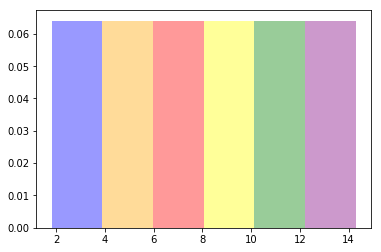

In [109]:
import seaborn as sns
sns.distplot(prompt_histogram.dropna())

In [86]:
hungup_ssask_summary_p = prompt_ssask_df[['rec_prompt_full','hungup_point','cal_duration']].groupby(['rec_prompt_full','hungup_point']).agg(['count','mean','min','max','sum']).reset_index()
hungup_ssask_summary_p.pivot(index='rec_prompt_full',columns='hungup_point')

# Majority (71%) of the people hang up after hearing the first question about hearing balance within an average of 6 seconds.

cal_duration             \
                                                          count              
hungup_point                                                  0     1    2   
rec_prompt_full                                                              
Would you like to use phone banking for this?              81.0   NaN  NaN   
Would you like to use phone banking to change a...         26.0   NaN  NaN   
Would you like to use phone banking to hear you...        115.0   1.0  NaN   
Would you like to use phone banking to hear you...       1871.0  52.0  NaN   
Would you like to use phone banking to make a b...        104.0   1.0  NaN   
Would you like to use phone banking to transfer...        825.0   6.0  NaN   
[I didn't get that.] Just after a yes or no for...         83.0   NaN  7.0   
[I didn't hear that.] Just after a yes or no fo...        106.0   NaN  6.0   
none none                                                5962.0   NaN  NaN   

                                                                          \
                                                         mean              
hungup_point                                                0          1   
rec_prompt_full                                                            
Would you like to use phone banking for this?        9.573877        NaN   
Would you like to use phone banking to change a...  11.030808        NaN   
Would you like to use phone banking to hear you...  11.739417   6.719000   
Would you like to use phone banking to hear you...  10.058117   5.915288   
Would you like to use phone banking to make a b...  10.458260  14.032000   
Would you like to use phone banking to transfer...   9.771824   5.144000   
[I didn't get that.] Just after a yes or no for...  28.227807        NaN   
[I didn't hear that.] Just after a yes or no fo...  22.278198        NaN   
none none                                            9.477081        NaN   

                                                                               \
                                                                  min           
hungup_point                                                2       0       1   
rec_prompt_full                                                                 
Would you like to use phone banking for this?             NaN   4.875     NaN   
Would you like to use phone banking to change a...        NaN   6.016     NaN   
Would you like to use phone banking to hear you...        NaN   3.047   6.719   
Would you like to use phone banking to hear you...        NaN   2.766   0.176   
Would you like to use phone banking to make a b...        NaN   2.656  14.032   
Would you like to use phone banking to transfer...        NaN   2.860   2.311   
[I didn't get that.] Just after a yes or no for...  26.192429   8.422     NaN   
[I didn't hear that.] Just after a yes or no fo...  14.876167  14.610     NaN   
none none                                                 NaN   0.176     NaN   

                                                                            \
                                                               max           
hungup_point                                             2       0       1   
rec_prompt_full                                                              
Would you like to use phone banking for this?          NaN  30.965     NaN   
Would you like to use phone banking to change a...     NaN  33.767     NaN   
Would you like to use phone banking to hear you...     NaN  49.077   6.719   
Would you like to use phone banking to hear you...     NaN  50.532  25.860   
Would you like to use phone banking to make a b...     NaN  43.712  14.032   
Would you like to use phone banking to transfer...     NaN  58.719   7.969   
[I didn't get that.] Just after a yes or no for...  19.032  58.719     NaN   
[I didn't hear that.] Just after a yes or no fo...  11.765  37.907     NaN   
none none                                              Na

In [132]:
52/60

0.8666666666666667

In [81]:
prompt_ssask_summary = prompt_ssask_df[['rec_prompt_full','rec_id','cal_duration']].groupby(['rec_prompt_full','rec_id']).agg(['count','mean','min','max','sum']).reset_index()

prompt_ssask_summary[['rec_prompt_full','rec_id','cal_duration']].pivot(index='rec_prompt_full',columns='rec_id')

# 6.4% of people need to be prompted to answer 'yes' or 'no', 

cal_duration          \
                                                          count           
rec_id                                                        1       2   
rec_prompt_full                                                           
Would you like to use phone banking for this?              81.0     NaN   
Would you like to use phone banking to change a...         26.0     NaN   
Would you like to use phone banking to hear you...        116.0     NaN   
Would you like to use phone banking to hear you...       1923.0     NaN   
Would you like to use phone banking to make a b...        105.0     NaN   
Would you like to use phone banking to transfer...        831.0     NaN   
[I didn't get that.] Just after a yes or no for...          NaN    89.0   
[I didn't hear that.] Just after a yes or no fo...          NaN   111.0   
none none                                                   NaN  2882.0   

                                                                       \
                                                                 mean   
rec_id                                                   3          1   
rec_prompt_full                                                         
Would you like to use phone banking for this?          NaN   9.573877   
Would you like to use phone banking to change a...     NaN  11.030808   
Would you like to use phone banking to hear you...     NaN  11.696138   
Would you like to use phone banking to hear you...     NaN   9.946090   
Would you like to use phone banking to make a b...     NaN  10.492295   
Would you like to use phone banking to transfer...     NaN   9.738410   
[I didn't get that.] Just after a yes or no for...     1.0        NaN   
[I didn't hear that.] Just after a yes or no fo...     1.0        NaN   
none none                                           3080.0        NaN   

                                                                          \
                                                                           
rec_id                                                      2          3   
rec_prompt_full                                                            
Would you like to use phone banking for this?             NaN        NaN   
Would you like to use phone banking to change a...        NaN        NaN   
Would you like to use phone banking to hear you...        NaN        NaN   
Would you like to use phone banking to hear you...        NaN        NaN   
Would you like to use phone banking to make a b...        NaN        NaN   
Would you like to use phone banking to transfer...        NaN        NaN   
[I didn't get that.] Just after a yes or no for...  27.958966  37.907000   
[I didn't hear that.] Just after a yes or no fo...  21.774586  33.767000   
none none                                            8.964036   9.957144   

                                                                           \
                                                      min                   
rec_id                                                  1       2       3   
rec_prompt_full                                                             
Would you like to use phone banking for this?       4.875     NaN     NaN   
Would you like to use phone banking to change a...  6.016     NaN     NaN   
Would you like to use phone banking to hear you...  3.047     NaN     NaN   
Would you like to use phone banking to hear you...  0.176     NaN     NaN   
Would you like to use phone banking to make a b...  2.656     NaN     NaN   
Would you like to use phone banking to transfer...  2.311     NaN     NaN   
[I didn't get that.] Just after a yes or no for...    NaN   8.422  37.907   
[I didn't hear that.] Just after a yes or no fo...    NaN  11.765  33.767   
none none                                             NaN   0.176   0.176   

                                                                            \
                                                       m

In [89]:
(89+111)/3082*100

6.489292667099286

In [25]:
# export information out to CSV for basic analysis

# prompt_rec_df.to_csv('/Users/vickyli/Documents/DS_P449_KiwiBank/prompt_ssask_df.csv', index = None, header=True)

In [27]:
# Build network of prompts

prompt_rec_df['uid'] = prompt_rec_df.index

prompt_rec_df_A = prompt_rec_df.add_prefix('_A_')
prompt_rec_df_B = prompt_rec_df.shift(periods=-1).add_prefix('_B_')

prompt_link_df = (pd.concat([prompt_rec_df_A, prompt_rec_df_B], axis=1, sort=False))

prompt_link_df.head()

_A_end_callData_cti_outbound_call_result _A_end_callData_cti_outbound_pd  \
0                                       OK                            none   
1                                       OK                            none   
2                                       OK                            none   
3                                       OK                            none   
4                                       OK                            none   

  _A_end_callData_cti_outbound_pt _A_end_callData_cti_outbound_pu  \
0                            none          stop_automatic_payment   
1                            none                        password   
2                            none                    new_customer   
3                            none                        password   
4                    term_deposit                            open   

   _A_end_duration _A_end_reason             _A_end_time _A_prompt10_source  \
0           17.079            OK 2019-04-30 12:40:04.238                NaN   
1           26.740            OK 2019-04-29 20:26:16.801                NaN   
2           12.578            OK 2019-04-29 16:33:17.727                NaN   
3           20.016            OK 2019-04-29 13:09:14.097                NaN   
4           12.762            OK 2019-04-24 11:31:39.475                NaN   

   _A_rec_duration          _A_rec_endTime  ...  \
0           16.923 2019-04-30 12:40:04.160  ...   
1           26.615 2019-04-29 20:26:16.748  ...   
2           12.407 2019-04-29 16:33:17.665  ...   
3           19.641 2019-04-29 13:09:14.034  ...   
4           12.646 2019-04-24 11:31:39.412  ...   

                                  _B_rec_prompt_full _B_rec_recal_duration  \
0  To help me direct you to the right place, plea...                26.615   
1  To help me direct you to the right place, plea...                12.407   
2  To help me direct you to the right place, plea...                19.641   
3  To help me direct you to the right place, plea...                12.646   
4  To help me direct you to the right place, plea...                10.578   

          _B_Pt _B_Pd         _B_Pu _B_Scriptid     _B_Queue _B_Tier  \
0          none  none      password         EXP      Express  Bronze   
1          none  none  new_customer         SNT          SNT  Silver   
2          none  none      password         EXP      Express  Bronze   
3  term_deposit  none          open         INV  Investments  Silver   
4       account   new           new         JON         Join    Gold   

  _B_rec_id _B_uid  
0       1.0    1.0  
1       1.0    2.0  
2       1.0    3.0  
3       1.0    4.0  
4       1.0    5.0  

[5 rows x 74 columns]

In [125]:
ssask_logs_df.loc[~ssask_logs_df['rec4_duration'].isna()].transpose()

6    \
end_callData_cti_outbound_call_result                                                 OK   
end_callData_cti_outbound_pd                                                         new   
end_callData_cti_outbound_pt                                                     account   
end_callData_cti_outbound_pu                                                         new   
end_duration                                                                      38.875   
end_reason                                                                            OK   
end_time                                                      2019-04-29 13:01:02.414000   
prompt10_source                        prompts/EN-AU/CallSteering/NewAccount_IsKBCust...   
prompt10_text                                     Are you an existing Kiwibank customer?   
prompt1_text                           To help me direct you to the right place, plea...   
prompt3_text                           To provide the best service I just need to kno...   
prompt4_text                           To help me direct you to the right place, plea...   
prompt5_text                                                                         NaN   
prompt6_text                           To provide the best service I just need to kno...   
prompt7_text                                                        [I didn't get that.]   
prompt8_text                                                                         NaN   
prompt9_text                           In just a few words please tell me the reason ...   
rec1_duration                                                                      7.172   
rec1_endTime                                                  2019-04-29 13:00:30.773000   
rec1_inputmode                                                                    speech   
rec1_reason                                                                           OK   
rec1_startTime                                                2019-04-29 13:00:23.601000   
rec1_state                                                                      OpenMenu   
rec1_utterance1                                                                      yes   
rec2_duration                                                                      5.297   
rec2_endTime                                                  2019-04-29 13:00:36.086000   
rec2_inputmode                                                                    speech   
rec2_reason                                                                           OK   
rec2_startTime                                                2019-04-29 13:00:30.789000   
rec2_state                                                                      OpenMenu   
rec2_utterance1                                                                   figure   
rec3_duration                                                                     12.782   
rec3_endTime                                                  2019-04-29 13:00:48.883000   
rec3_inputmode                                                                    speech   
rec3_reason                                                                           OK   
rec3_startTime                                                2019-04-29 13:00:36.101000   
rec3_state                                                                      OpenMenu   
rec3_utterance1                                                          new new account   
rec4_duration                                                                     13.422   
rec4_endTime                                                  2019-04-29 13:01:02.336000   
rec4_inputmode                                                                    speech   
rec4_reason                                                                           OK   
rec4_startTime                                                2019-04-29 13:00:48.914000   
rec4_state                           

In [65]:
file = '/Users/vickyli/Documents/DS_P449_KiwiBank/data_unzip/AKL_04_24/24/14/143118-A6BBE01C1FFAB89D0D0C774BB17B224F/kbva.calllog.clean'
show_file(file)



D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_04_24\24\14\143118-A6BBE01C1FFAB89D0D0C774BB17B224F\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_04_24\24\14\143118-A6BBE01C1FFAB89D0D0C774BB17B224F\kbva.calllog
#=====================================================================
start.time=24/04/2019 14:31:18.715
start.sessionID=A6BBE01C1FFAB89D0D0C774BB17B224F
start.callData.call.request.anum=
start.callData.call.request.dnis=94405928
start.callData.call.request.env=sak
start.callData.call.request.module=ssask
start.callData.call.request.ref=152784.24482
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=To help me direct you to the right place, please tell me how I can help you today.
prompt[3].text=To provide the best service I just need to know a little about your enquiry so, in your own words please tell me the reason for your call.
#=============================================

In [ ]:
ssask_logs = []
for file in files_ssask:
   entry={‘file’: file}
   with open(file) as f:
       for line in f.readlines():
           if line.startswith(‘start’):
               x,y = line.split(‘=’)
               entry[‘_’.join(x.split(‘.’)[-2:])] = y.rstrip()

           if line.startswith(‘rec[1].state’):
               x,y = line.split(‘=’)
               entry[‘rec1_state’] = y.rstrip()
           if line.startswith(‘rec[1].inputmode’):
               x,y = line.split(‘=’)
               entry[‘rec1_inputmode’] = y.rstrip()
           if line.startswith(‘rec[1].duration’):
               x,y = line.split(‘=’)
               entry[‘rec1_duration’] = y.rstrip()

           if line.startswith(‘rec[2].state’):
               x,y = line.split(‘=’)
               entry[‘rec2_state’] = y.rstrip()
           if line.startswith(‘rec[2].inputmode’):
               x,y = line.split(‘=’)
               entry[‘rec2_inputmode’] = y.rstrip()
           if line.startswith(‘rec[2].duration’):
               x,y = line.split(‘=’)
               entry[‘rec2_duration’] = y.rstrip()

           if line.startswith(‘rec[3].state’):
               x,y = line.split(‘=’)
               entry[‘rec3_state’] = y.rstrip()
           if line.startswith(‘rec[3].inputmode’):
               x,y = line.split(‘=’)
               entry[‘rec3_inputmode’] = y.rstrip()
           if line.startswith(‘rec[3].duration’):
               x,y = line.split(‘=’)
               entry[‘rec3_duration’] = y.rstrip()

           if line.startswith(‘end’):
               x,y = line.split(‘=’)
               entry[‘_’.join(x.split(‘.’)[-2:])] = y.rstrip()
       ssask_logs.append(entry)

ssask_logs_df = pd.DataFrame.from_dict(ssask_logs).drop([‘request_module’],axis=1)
ssask_logs_df[‘end_duration’] = ssask_logs_df[‘end_duration’].apply(lambda x: float(x[:-1]))

ssask_logs_df.replace(r’^\s*$’, ‘none’, regex=True,inplace=True)

In [39]:
file_txt = ''

for f in ssask_files:
    file = '/Users/vickyli/Documents/DS_P449_KiwiBank/' + f
    file_txt = file_txt + open(file).read()

print(file_txt)


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_04_26\26\10\104001-5721E20162B7995B93F6073E9FB31508\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_04_26\26\10\104001-5721E20162B7995B93F6073E9FB31508\kbva.calllog
#=====================================================================
start.time=26/04/2019 10:40:01.447
start.sessionID=5721E20162B7995B93F6073E9FB31508
start.callData.call.request.anum=
start.callData.call.request.dnis=94405928
start.callData.call.request.env=sak
start.callData.call.request.module=ssask
start.callData.call.request.ref=152786.11665
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=To help me direct you to the right place, please tell me how I can help you today.
prompt[3].text=To provide the best service I just need to know a little about your enquiry so, in your own words please tell me the reason for your call.
#=============================================